In [ ]:
!pip install torch torchvision torchmetrics albumentations opencv-python

# Preparation of milestone three

Today we will start preparing the third milestone. The third milestone is to train an object detector to recognize cells. To successfully complete the milestone, you will have to complete the following sub-tasks:
- Initialize a pytorch object detector. I'd suggest to choose a RetinaNet or FCOS detection model. More Information can be found [here](https://pytorch.org/vision/stable/models.html#object-detection-instance-segmentation-and-person-keypoint-detection). Since we do not have endless compute power available, we will use a pre-trained backbone and only train the detection and classification heads of our object detector. So you will have to finde a way to **freeze** the backbone of your detector.
- You will have to write a [training and validation/test](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html) loop to train your detector. Make sure you measure the convergence of the training by monitoring a detection metric like the [mAP](https://torchmetrics.readthedocs.io/en/stable/detection/mean_average_precision.html). Also, you will have to find a way to select the best model during training based on some metric. The detection models of torchvision already return a loss when they are in evaluation mode, so you don't need to configure your own one.
- Train your model for a few epochs. If you do not have a gpu available, I suggest using colab, as training the model on the cpu is extremely slow. You will also need to pass your dataset to a dataloader to take advantage of multithreading and automatic batching.
- At the end, you will have to save the **state_dict** of your trained object detector, to be able to reuse it later.

Please use a jupyter notebook for coding your training/testing pipeline. In the end, you will have to submit that jupiter notebook at moodle. Please do not try to upload any model weights.

In [ ]:
from google.colab import drive
import os
import pandas as pd
import numpy as np
import torch
import random
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torchvision
from torchvision.models.detection import RetinaNet
from torchvision.models.detection.retinanet import RetinaNetClassificationHead, AnchorGenerator
from torchvision.models import MobileNet_V2_Weights
from tqdm import tqdm
from torchmetrics.detection.mean_ap import MeanAveragePrecision

# If you run the notebook in colab, you have to mount the google drive with the images. Proceed as follows:

- **First**: Open the following **[link](https://drive.google.com/drive/folders/18P74V8kli6qDZtGBLN-tPrJFu3O2NPEK?usp=sharing)** in a new tab.
- **Second**: Add a link to your google Drive.
Example: [Link](https://drive.google.com/file/d/1IcFGGIoktPkDj9-4j5IQ3evInn0c2aq-/view?usp=sharing)
- **Third**: Run the line of code below
- **Fourth**: Grant Google access to your Drive

In [ ]:
# path to the link you created
annotations_path = '/content/gdrive/MyDrive/AgNORs/annotation_frame.p'
path_to_slides = '/content/gdrive/MyDrive/AgNORs/'

# mount the data
drive.mount('/content/gdrive')
annotations = pd.read_pickle(annotations_path)
print(annotations.head())
print(annotations.columns)
df = pd.read_csv(path_to_slides +"annotation_frame.csv")
unique_filenames = df['filename'].unique()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
          filename  max_x  max_y  min_x  min_y  label
0  AgNOR_0495.tiff     26     41      4     15      1
1  AgNOR_0495.tiff     71     23     42      0      2
2  AgNOR_0495.tiff    133     61    104     37      1
3  AgNOR_0495.tiff    143    117    121     88      2
4  AgNOR_0495.tiff    224     37    199     12      1
Index(['filename', 'max_x', 'max_y', 'min_x', 'min_y', 'label'], dtype='object')


# 1. Create a Custom Dataset Class for training your object detection model

In the last milestone, you learned about custom data sets in pytorch. In this milestone, we are going to train an object detection model, for which we also need a custom dataset. Last time, the dataset returned only one cell each time the getitem method was called. This time, we need to return a larger portion of the image to feed the object detector. Since there may be more than one cell in the image, you will also need to return the labels and bounding box information for each cell in the respective crop. Think about how to deal with cells that are at the edges of the crop and therefore not completely visible. Also consider what to do if there is no annotation on the image.

Your dataset must have the following characteristics:

1. Since you are going to randomly sample the crops from the images, you need a parameter that defines how many crops will be sampled in an epoch (num_samples).
2. You need to define the size of the patches that will be sampled from the images during training (crop_size).
3. Since we do not have many images available, we will need image augmentation. Geometric augmentations are a bit tricky for object detection, because you always have to transform the bounding boxes as well. The [albumentations](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/) module solves this quite nicely, so I suggest using it for the augmentations in this task.
4. Have a look at pytorch and torchmetrics to see in which format the metrics as well as the models expect the images and tragets.
5. Although we do not actively detect a background class, the label "0" is always reserved for the background class. Therefore, your dataset must return the label "1" for each cell.

In [ ]:
total_images = len(unique_filenames)
train_size = int(total_images * 0.8)
test_size = int(total_images * 0.1)
validation_size = total_images - train_size - test_size

train_images = unique_filenames[:train_size]
test_images = unique_filenames[train_size:train_size + test_size]
validation_images = unique_filenames[train_size + test_size:]

train_df = df[df['filename'].isin(train_images)]
test_df = df[df['filename'].isin(test_images)]
validation_df = df[df['filename'].isin(validation_images)]

validation_df

,filename,max_x,max_y,min_x,min_y,label
17841,AgNOR_2852.tiff,49,107,13,79,1
17842,AgNOR_2852.tiff,49,183,7,140,5
17843,AgNOR_2852.tiff,202,156,159,114,3
17844,AgNOR_2852.tiff,234,82,189,40,6
17845,AgNOR_2852.tiff,284,126,232,87,9
...,...,...,...,...,...,...
19859,AgNOR_0677.tiff,362,994,335,969,2
19860,AgNOR_0677.tiff,1273,923,1250,899,0
19861,AgNOR_0677.tiff,787,1121,758,1093,0
19862,AgNOR_0677.tiff,780,1159,759,1138,0


(tensor([[[ 1.5982,  1.5125,  1.4612,  ...,  1.2728,  1.0673,  1.0844],
         [ 1.6667,  1.6667,  1.6838,  ...,  1.2214,  1.1872,  1.2385],
         [ 1.3070,  1.3755,  1.4783,  ...,  1.2043,  1.3755,  1.4612],
         ...,
         [ 1.3927,  0.8618,  0.2111,  ...,  1.2899,  1.0844,  0.9988],
         [ 1.8208,  1.5639,  0.8618,  ...,  1.3070,  0.9132,  0.8961],
         [ 1.8893,  1.5297,  0.9474,  ...,  1.2214,  0.9646,  0.9474]],

        [[ 1.3782,  1.3606,  1.3431,  ...,  0.9055,  1.1331,  1.1856],
         [ 1.4307,  1.4482,  1.5007,  ...,  0.9930,  1.2731,  1.3256],
         [ 1.0455,  1.0980,  1.2031,  ...,  1.1331,  1.4832,  1.5182],
         ...,
         [ 0.9580,  0.4153, -0.2325,  ...,  1.0630,  0.6954,  0.7129],
         [ 1.5357,  1.2731,  0.5553,  ...,  1.0630,  0.4853,  0.5553],
         [ 1.5882,  1.2556,  0.6779,  ...,  0.9930,  0.4853,  0.5553]],

        [[ 0.4614,  0.3742,  0.3045,  ...,  0.3742,  0.6705,  0.6705],
         [ 0.5136,  0.5136,  0.5311,  ...,  

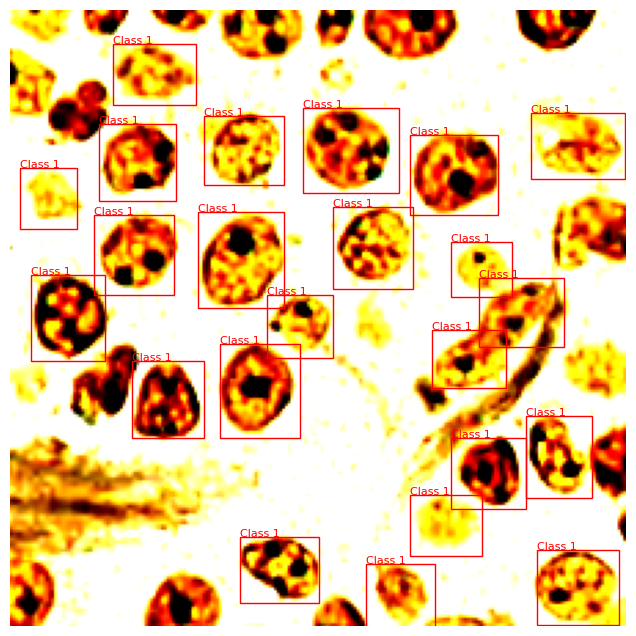

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
class CustomAugmentation:
    def guassian_blur(self, img):
        kernel_size = np.random.choice([3, 5, 7])
        img_np = np.array(img)
        blurred_img = np.zeros_like(img_np)
        for i in range(img_np.shape[2]):
            blurred_img[:, :, i] = self.convolution(img_np[:, :, i], self.gaussian_kernel(kernel_size))
        blurred_img_pil = Image.fromarray(blurred_img)
        return blurred_img_pil

    def color_jitter(self, image, brightness=1, contrast=2.5, saturation=1.5, hue=0.5):
        image = transforms.functional.adjust_brightness(image, brightness)
        image = transforms.functional.adjust_contrast(image, contrast)
        image = transforms.functional.adjust_saturation(image, saturation)
        image = transforms.functional.adjust_hue(image, hue)
        return image

    def gaussian_kernel(self, size, sigma=1):
        kernel = np.fromfunction(lambda x, y: (1 / (2 * np.pi * sigma ** 2)) * np.exp(
            -(x - size // 2) ** 2 / (2 * sigma ** 2) - (y - size // 2) ** 2 / (2 * sigma ** 2)), (size, size))
        return kernel / np.sum(kernel)

    def convolution(self, img, kernel):
        padding = kernel.shape[0] // 2
        img_padded = np.pad(img, padding, mode='constant')
        convolved_img = np.zeros_like(img)
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                convolved_img[i, j] = np.sum(img_padded[i:i + kernel.shape[0], j:j + kernel.shape[1]] * kernel)
        return convolved_img

class AGNORsDataset(Dataset):
    def __init__(self, df, num_samples_per_epoch, crop_size, root_dir, transforms=None):
        self.df = df
        self.root_dir = root_dir
        self.num_samples_per_epoch = num_samples_per_epoch
        self.crop_size = crop_size
        self.transforms = transforms

    def __len__(self):
        return self.num_samples_per_epoch

    def __getitem__(self, idx):
        img_idx = random.randint(0, len(self.df) - 1)
        img_path = os.path.join(self.root_dir, self.df.iloc[img_idx, 0])
        row = self.df.iloc[img_idx]
        image_name = row['filename']
        with Image.open(img_path) as image:
            image = image.convert("RGB")
            image_np = np.array(image)
            h, w, _ = image_np.shape
            x1 = random.randint(0, w - self.crop_size[1])
            y1 = random.randint(0, h - self.crop_size[0])
            x2 = x1 + self.crop_size[1]
            y2 = y1 + self.crop_size[0]
            img_crop = image_np[y1:y2, x1:x2]
            b_boxes = []
            for _, rw in self.df[self.df['filename'] == image_name].iterrows():
                xmin, ymin, xmax, ymax = rw['min_x'], rw['min_y'], rw['max_x'], rw['max_y']
                if xmin >= x1 and xmax <= x2 and ymin >= y1 and ymax <= y2:
                    xmin = max(xmin - x1, 0)
                    ymin = max(ymin - y1, 0)
                    xmax = min(xmax - x1, self.crop_size[1])
                    ymax = min(ymax - y1, self.crop_size[0])
                    b_boxes.append([xmin, ymin, xmax, ymax])
            if len(b_boxes) == 0:
                labels = np.array([0])
                b_boxes = np.array([[0, 0, self.crop_size[1], self.crop_size[0]]])
            else:
                labels = np.ones(len(b_boxes), dtype=np.int32)
            if self.transforms:
                transformed = self.transforms(image=img_crop, bboxes=b_boxes, labels=labels)
                img_crop = transformed['image']
                b_boxes = torch.tensor(transformed['bboxes'], dtype=torch.float32)
                labels = torch.tensor(transformed['labels'], dtype=torch.int64)
            target = {
                'boxes': b_boxes,
                'labels': labels
            }
        return img_crop, target

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

train_data = AGNORsDataset(train_df, num_samples_per_epoch=6, crop_size=(224, 224), root_dir=path_to_slides, transforms=transform)
test_data = AGNORsDataset(test_df, num_samples_per_epoch=6, crop_size=(224, 224), root_dir=path_to_slides, transforms=transform)
validation_data = AGNORsDataset(validation_df, num_samples_per_epoch=6, crop_size=(224, 224), root_dir=path_to_slides, transforms=transform)

for _ in range(100):
    print(train_data[_])

def visualize(image, target):
    if image.shape[0] == 3 and image.shape[1] == 224 and image.shape[2] == 224:
        image = np.transpose(image, (1, 2, 0))
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    ax = plt.gca()
    for bbox, label in zip(target['boxes'], target["labels"]):
        xmin, ymin, xmax, ymax = bbox
        width = xmax - xmin
        height = ymax - ymin
        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(xmin, ymin, f'Class {label}', fontsize=8, color='r')
    plt.axis('off')
    plt.show()

idx = 0
image, target = train_data.__getitem__(idx)
visualize(image, target)

def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(train_data, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)
validation_loader = DataLoader(validation_data, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)

# 2. Initializing the model

Initialize a pre-trained object detector from torchvision. Since you need to detect cells, you need two classes (a background class and a "cell" class). Some detection models like FasterRCNN or Retinanet use anchor boxes. If you choose to work with one of these models, you will need to select anchorboxes with a size that matches the size of the detection targets.

In [ ]:
backbone = torchvision.models.mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT).features
backbone.out_channels = 1280
anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)
model = RetinaNet(backbone,
                  num_classes=2,
                  anchor_generator=anchor_generator)

model

RetinaNet(
  (backbone): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e

# 3. Setting up an optimzer, a detection metric and the train and validation dataloaders

To train the object detector, it is necessary to select an appropriate optimiser. Additionally, the torchmetrics class needs to be instantiated before it can be used for evaluation or tracking metrics during training.
Additionally, initialize a training and validation dataloader your dataset. For more information on how to set up your dataloaders have a look [here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)


In [ ]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
torch.cuda.is_available()
metric = MeanAveragePrecision()

# 4. Train and validation loop

Please write two functions, one for training and one for evaluating your object detector. The functionality should be very similar to what you had to do for the last milestone. Use these functions to train the detector for a few epochs. During training, track both the training losses and the validation metrics to monitor the performance of the model. Save the best detector as observed by the validation metric.

In [ ]:
num_epochs = 5
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for i, (images, targets) in enumerate(train_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()
        epoch_loss += losses.item()
        print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {losses.item():.4f}")
    lr_scheduler.step()
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {epoch_loss/len(train_loader):.4f}")

def validation(val_loader, model, device='cpu', epoch=1):
    running_loss = 0.0
    metric = MeanAveragePrecision()
    model.eval()
    with torch.no_grad():
        for i, (images, targets) in tqdm(enumerate(val_loader, 0), total=np.ceil(len(val_loader.dataset) / val_loader.batch_size)):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            predictions = model(images)
            metric.update(predictions, targets)
    metrics_values = metric.compute()
    print(f"\nmAP 50: {metrics_values['map_50']:.3f}\n")
    return metrics_values

Epoch [1/5], Step [1/2], Loss: 2.2531
Epoch [1/5], Step [2/2], Loss: 3.0523
Epoch [1/5] Loss: 2.6527
Epoch [2/5], Step [1/2], Loss: 2.5604
Epoch [2/5], Step [2/2], Loss: 1.3018
Epoch [2/5] Loss: 1.9311
Epoch [3/5], Step [1/2], Loss: 2.8611
Epoch [3/5], Step [2/2], Loss: 2.0476
Epoch [3/5] Loss: 2.4543
Epoch [4/5], Step [1/2], Loss: 1.9100
Epoch [4/5], Step [2/2], Loss: 1.8105
Epoch [4/5] Loss: 1.8603
Epoch [5/5], Step [1/2], Loss: 1.9671
Epoch [5/5], Step [2/2], Loss: 1.8732
Epoch [5/5] Loss: 1.9201
